In [9]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import cv2
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as BE
from tensorflow.keras.losses import categorical_crossentropy
from progressbar import ProgressBar
import os
import scipy.io
import tensorflow as tf
import json
import sys
sys.path.append('..')  
from GradPri_utils.utils import *
import pandas as pd
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Bar
import xgboost
from sklearn import model_selection

# from tensorflow.keras import backend as BE
# from Integrated_Gradients_algorithm import *
# from GradVisualizer import *

os.environ["CUDA_VISIBLE_DEVICES"] = "4"
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.compat.v1.Session(config=config) 

# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

In [2]:
total_sample_num = 3000
data = np.load('./featureExtraction/ImageNet_'+str(total_sample_num)+'samplesGradientFeature.npy',allow_pickle=True)

In [3]:
data.item().keys()

dict_keys(['ground_truth_label', 'predicted_confidence', 'binary_flag', 'gradients', 'firProb_gradient_sum', 'secProb_gradient_sum'])

In [4]:
# 绘制最高置信度和梯度绝对值和的直方图
max_predicted_confidence = []
sec_predicted_confidence = []
sum_gradients = []

right_sec_predicted_confidence = []
right_max_predicted_confidence = []
right_sum_gradients = []

wrong_max_predicted_confidence = []
wrong_sec_predicted_confidence = []
wrong_sum_gradients = []

secProb_gradient_sum = []
right_secProb_gradient_sum = []
wrong_secProb_gradient_sum = []

pbar = ProgressBar()
for i in pbar(range(0,total_sample_num)):
    max_predicted_confidence.append(  np.max(data.item()['predicted_confidence'][i])  )
    sum_gradients.append(  np.sum(np.abs(data.item()['gradients'][i]))  )
    secProb_gradient_sum.append( data.item()['secProb_gradient_sum'][i] )
    tmp1 = data.item()['predicted_confidence'][i].copy()
    tmp1[0][np.argmax(data.item()['predicted_confidence'][i])] = -1
    sec_predicted_confidence.append(  data.item()['predicted_confidence'][i][0][np.argmax(tmp1)]  )
    if data.item()['binary_flag'][i]==1:
        right_max_predicted_confidence.append(  np.max(data.item()['predicted_confidence'][i])  )
        right_sum_gradients.append(  np.sum(np.abs(data.item()['gradients'][i]))  )
        right_secProb_gradient_sum.append( data.item()['secProb_gradient_sum'][i] )
        right_sec_predicted_confidence.append(  data.item()['predicted_confidence'][i][0][np.argmax(tmp1)]  )
    if data.item()['binary_flag'][i]==0:
        wrong_max_predicted_confidence.append(  np.max(data.item()['predicted_confidence'][i])  )
        wrong_sum_gradients.append(  np.sum(np.abs(data.item()['gradients'][i]))  )
        wrong_secProb_gradient_sum.append( data.item()['secProb_gradient_sum'][i] )
        wrong_sec_predicted_confidence.append(  data.item()['predicted_confidence'][i][0][np.argmax(tmp1)]  )

100% |########################################################################|


In [5]:
max_predicted_confidence = np.array(max_predicted_confidence)
sum_gradients = np.array(sum_gradients)
right_max_predicted_confidence = np.array(right_max_predicted_confidence)
right_sum_gradients = np.array(right_sum_gradients)
wrong_max_predicted_confidence = np.array(wrong_max_predicted_confidence)
wrong_sum_gradients = np.array(wrong_sum_gradients)
print(np.shape(max_predicted_confidence), 
      np.shape(right_max_predicted_confidence), 
      np.shape(wrong_max_predicted_confidence))

(3000,) (1976,) (1024,)


In [6]:
def histogram_plot(bins, data, name_str):
    hist,bin_edges = np.histogram(data,bins=bins)
    bar=(
        Bar()
        .add_xaxis([str(x) for x in bin_edges[:-1]])
        .add_yaxis("",[float(x) for x in hist],category_gap=0)
        .set_global_opts(
            title_opts=opts.TitleOpts(title=name_str,pos_left="center"),
            legend_opts=opts.LegendOpts(is_show=False)
        )
    )
    bar.render('./histogram/' + name_str+".html")

In [39]:
bins = 30
histogram_plot(bins=bins, data=max_predicted_confidence, name_str='max_predicted_confidence')
histogram_plot(bins=bins, data=sum_gradients, name_str='sum_gradients')
histogram_plot(bins=bins, data=secProb_gradient_sum, name_str='secProb_gradient_sum')
histogram_plot(bins=bins, data=right_max_predicted_confidence, name_str='right_max_predicted_confidence')
histogram_plot(bins=bins, data=right_sum_gradients, name_str='right_sum_gradients')
histogram_plot(bins=bins, data=right_secProb_gradient_sum, name_str='right_secProb_gradient_sum')
histogram_plot(bins=bins, data=wrong_max_predicted_confidence, name_str='wrong_max_predicted_confidence')
histogram_plot(bins=bins, data=wrong_sum_gradients, name_str='wrong_sum_gradients')
histogram_plot(bins=bins, data=wrong_secProb_gradient_sum, name_str='wrong_secProb_gradient_sum')

Text(0, 0.5, 'right_sec_predicted_confidence')

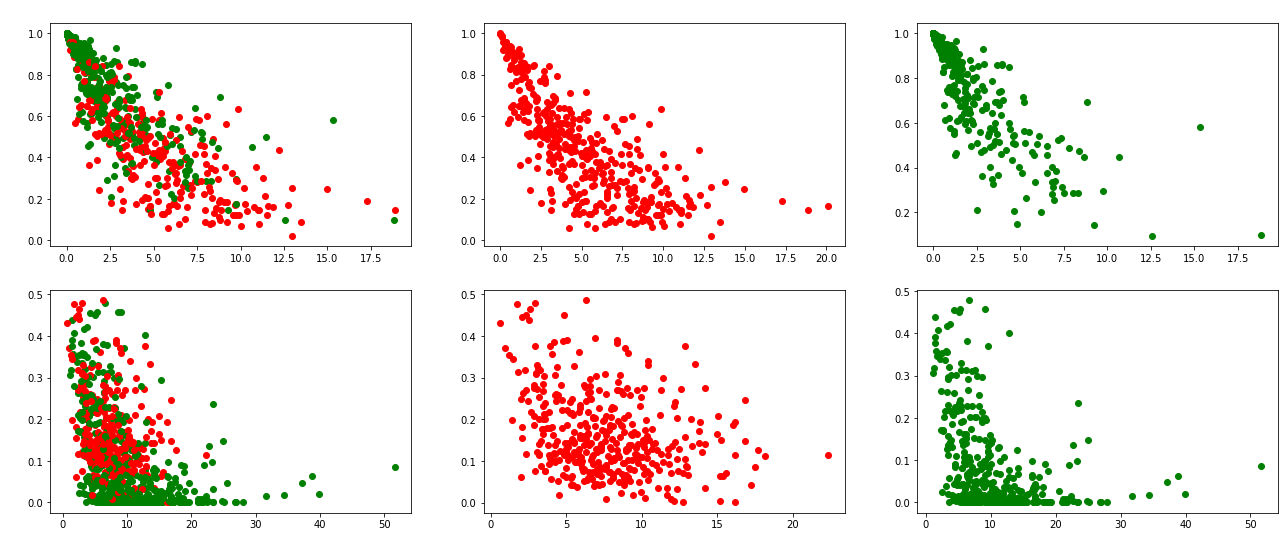

In [55]:
figure = plt.figure(figsize=(22,9))
points_num = 400

plt.subplot(231)
for i in range(0, points_num*2):
    if data.item()['binary_flag'][i]==0:
        plt.plot(sum_gradients[i], max_predicted_confidence[i], 'or' )
    else:
        plt.plot(sum_gradients[i], max_predicted_confidence[i], 'og' )
#设置图表参数
plt.xlabel('sum_gradients', fontsize = 15, color = 'white')   #设置x轴标签
plt.ylabel('max_predicted_confidence', fontsize = 15, color = 'white')   #设置y轴标签

plt.subplot(232)
plt.plot(wrong_sum_gradients[0:points_num], wrong_max_predicted_confidence[0:points_num], 'or' )
plt.xlabel('wrong_sum_gradients', fontsize = 15, color = 'white')   #设置x轴标签
plt.ylabel('wrong_max_predicted_confidence', fontsize = 15, color = 'white')   #设置y轴标签

plt.subplot(233)
plt.plot(right_sum_gradients[0:points_num], right_max_predicted_confidence[0:points_num], 'og' )
plt.xlabel('right_sum_gradients', fontsize = 15, color = 'white')   #设置x轴标签
plt.ylabel('right_max_predicted_confidence', fontsize = 15, color = 'white')   #设置y轴标签

plt.subplot(234)
for i in range(0, points_num*2):
    if data.item()['binary_flag'][i]==0:
        plt.plot(secProb_gradient_sum[i], sec_predicted_confidence[i], 'or' )
    else:
        plt.plot(secProb_gradient_sum[i], sec_predicted_confidence[i], 'og' )
plt.xlabel('secProb_gradient_sum', fontsize = 15, color = 'white')   #设置x轴标签
plt.ylabel('sec_predicted_confidence', fontsize = 15, color = 'white')   #设置y轴标签

plt.subplot(235)
plt.plot(wrong_secProb_gradient_sum[0:points_num], wrong_sec_predicted_confidence[0:points_num], 'or' )
plt.xlabel('wrong_secProb_gradient_sum', fontsize = 15, color = 'white')   #设置x轴标签
plt.ylabel('wrong_sec_predicted_confidence', fontsize = 15, color = 'white')   #设置y轴标签

plt.subplot(236)
plt.plot(right_secProb_gradient_sum[0:points_num], right_sec_predicted_confidence[0:points_num], 'og' )
plt.xlabel('right_secProb_gradient_sum', fontsize = 15, color = 'white')   #设置x轴标签
plt.ylabel('right_sec_predicted_confidence', fontsize = 15, color = 'white')   #设置y轴标签

In [92]:
X_xgboost = []
Y_xgboost = []
pbar = ProgressBar()
for i in pbar(range(0,total_sample_num)):
#     tmp1 = np.squeeze(np.sum(np.abs(data.item()['gradients'][i]), axis=-1 ), axis=0)
    X_xgboost.append( np.reshape( np.sum(np.abs(data.item()['gradients'][i]), axis=-1 ), (-1)) )
    if data.item()['binary_flag'][i]: # 若没有误分类
        Y_xgboost.append( 1-data.item()['binary_flag'][i] )
    else:  # 若被误分类
        Y_xgboost.append( 1-data.item()['binary_flag'][i] )
    
Y_xgboost = np.array(Y_xgboost)
X_xgboost = np.array(X_xgboost)

100% |########################################################################|


In [161]:
train_num_xgboost = 2000  # 用于训练的样本数
bottom_train_xgboost = range(total_sample_num-train_num_xgboost, total_sample_num)  # 后bottom_train_num_xgboost个作为训练的样本
xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_xgboost[bottom_train_xgboost], Y_xgboost[bottom_train_xgboost])

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=80,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
# 预测xgboost的测试集部分
top_test_xgboost = range(0, 1000)  # 前top_test_num_xgboost个作为测试的样本
top_set = 1
predicted_confidence = data.item()['predicted_confidence']
ground_truth_label = data.item()['ground_truth_label']

y_pred_xgboost = xg_reg.predict(X_xgboost[top_test_xgboost])
indexs = np.argsort(y_pred_xgboost)
indexs = indexs[::-1]
APFD,_,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[top_test_xgboost],
                              predicted_confidence=np.array(predicted_confidence[top_test_xgboost]), 
                              top_set=top_set, decode_predictions=decode_predictions)
print("APFD: ", APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[top_test_xgboost], 
                predicted_confidence=np.array(predicted_confidence[top_test_xgboost]), 
                    top_set=top_set, decode_predictions=decode_predictions)
print("RAUC: ", RAUC)

In [6]:
X_DNN_reg = []
Y_DNN_reg = []
pbar = ProgressBar()
for i in pbar(range(0,total_sample_num)):
#     tmp1 = np.squeeze(np.sum(np.abs(data.item()['gradients'][i]), axis=-1 ), axis=0)
    X_DNN_reg.append( np.reshape( data.item()['gradients'][i], (224,224,3)) )
    if data.item()['binary_flag'][i]: # 若没有误分类
        Y_DNN_reg.append( 1-data.item()['binary_flag'][i] )
    else:  # 若被误分类
        Y_DNN_reg.append( 1-data.item()['binary_flag'][i] )
    
X_DNN_reg = np.array(X_DNN_reg)
Y_DNN_reg = np.array(Y_DNN_reg)
# Y_DNN_reg = to_categorical(Y_DNN_reg, 2)

100% |########################################################################|


In [7]:
print(np.shape( X_DNN_reg ), np.shape( Y_DNN_reg ))

(3000, 224, 224, 3) (3000,)


In [8]:
train_num_DNN_reg = 2000  # 用于训练的样本数
bottom_train_DNN_reg = range(total_sample_num-train_num_DNN_reg, total_sample_num)
input_shape = (224,224,3)

model_reg = Sequential()
# model.add(Lambda(augment_2d,
#                  input_shape=x_train.shape[1:],
#                  arguments={'rotation': 8.0, 'horizontal_flip': True}))
# Block 1
model_reg.add(Conv2D(64, (3, 3), padding='same', name = 'block1_conv1', input_shape=input_shape))
model_reg.add(BatchNormalization(name = 'block1_bn1'))
model_reg.add(Activation('relu', name = 'block1_act1'))

model_reg.add(Conv2D(64, (3, 3), padding='same', name = 'block1_conv2'))
model_reg.add(BatchNormalization(name = 'block1_bn2'))
model_reg.add(Activation('relu', name = 'block1_act2'))

model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool'))
model_reg.add(Dropout(0.25, name='block1_drop'))

# Block 2
model_reg.add(Conv2D(128, (3, 3), padding='same', name = 'block2_conv1'))
model_reg.add(BatchNormalization(name = 'block2_bn1'))
model_reg.add(Activation('relu', name = 'block2_act1'))

model_reg.add(Conv2D(128, (3, 3), padding='same', name = 'block2_conv2'))
model_reg.add(BatchNormalization(name = 'block2_bn2'))
model_reg.add(Activation('relu', name = 'block2_act2'))

model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool'))
model_reg.add(Dropout(0.25, name='block2_drop'))

# Block 3
model_reg.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv1'))
model_reg.add(BatchNormalization(name = 'block3_bn1'))
model_reg.add(Activation('relu', name = 'block3_act1'))

model_reg.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv2'))
model_reg.add(BatchNormalization(name = 'block3_bn2'))
model_reg.add(Activation('relu', name = 'block3_act2'))

model_reg.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv3'))
model_reg.add(BatchNormalization(name = 'block3_bn3'))
model_reg.add(Activation('relu', name = 'block3_act3'))

model_reg.add(Conv2D(256, (3, 3), padding='same', name = 'block3_conv4'))
model_reg.add(BatchNormalization(name = 'block3_bn4'))
model_reg.add(Activation('relu', name = 'block3_act4'))

model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool'))
model_reg.add(Dropout(0.25, name='block3_drop'))

# Block 4
model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv1'))
model_reg.add(BatchNormalization(name = 'block4_bn1'))
model_reg.add(Activation('relu', name = 'block4_act1'))

model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv2'))
model_reg.add(BatchNormalization(name = 'block4_bn2'))
model_reg.add(Activation('relu', name = 'block4_act2'))

model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv3'))
model_reg.add(BatchNormalization(name = 'block4_bn3'))
model_reg.add(Activation('relu', name = 'block4_act3'))

model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block4_conv4'))
model_reg.add(BatchNormalization(name = 'block4_bn4'))
model_reg.add(Activation('relu', name = 'block4_act4'))

model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool'))
model_reg.add(Dropout(0.25, name='block4_drop'))

# Block 5
model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block5_conv1'))
model_reg.add(BatchNormalization(name = 'block5_bn1'))
model_reg.add(Activation('relu', name = 'block5_act1'))

model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block5_conv2'))
model_reg.add(BatchNormalization(name = 'block5_bn2'))
model_reg.add(Activation('relu', name = 'block5_act2'))

model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block5_conv3'))
model_reg.add(BatchNormalization(name = 'block5_bn3'))
model_reg.add(Activation('relu', name = 'block5_act3'))

model_reg.add(Conv2D(512, (3, 3), padding='same', name = 'block5_conv4'))
model_reg.add(BatchNormalization(name = 'block5_bn4'))
model_reg.add(Activation('relu', name = 'block5_act4'))

model_reg.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool'))
model_reg.add(Dropout(0.25, name='block5_drop'))

# include_top
model_reg.add(Flatten(name='flatten'))
model_reg.add(Dense(4096, activation='relu', name='fc1'))
model_reg.add(Dropout(0.5, name='drop1'))
model_reg.add(Dense(4096, activation='relu', name='fc2'))
model_reg.add(Dropout(0.5, name='drop2'))
model_reg.add(Dense(1, activation='sigmoid', name='predictions'))

optimizers = tf.keras.optimizers.Adam(lr=0.00001)
model_reg.compile(optimizer=optimizers, loss='mae', metrics=['mse'])

model_reg.fit(X_DNN_reg[bottom_train_DNN_reg], Y_DNN_reg[bottom_train_DNN_reg], epochs=20, batch_size=64)

/public/liujiawei/anaconda3/envs/ZHB_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
32/32 [==============================] - 27s 322ms/step - loss: 0.2962 - mse: 0.2477
Epoch 2/20
32/32 [==============================] - 9s 291ms/step - loss: 0.2525 - mse: 0.2342
Epoch 3/20
32/32 [==============================] - 9s 296ms/step - loss: 0.2467 - mse: 0.2284
Epoch 4/20
32/32 [==============================] - 10s 303ms/step - loss: 0.2477 - mse: 0.2340
Epoch 5/20
32/32 [==============================] - 10s 305ms/step - loss: 0.2543 - mse: 0.2389
Epoch 6/20
32/32 [==============================] - 10s 304ms/step - loss: 0.2516 - mse: 0.2368
Epoch 7/20
32/32 [==============================] - 10s 306ms/step - loss: 0.2480 - mse: 0.2354
Epoch 8/20
32/32 [==============================] - 10s 305ms/step - loss: 0.2476 - mse: 0.2374
Epoch 9/20
32/32 [==============================] - 10s 310ms/step - loss: 0.2462 - mse: 0.2346
Epoch 10/20
32/32 [==============================] - 10s 302ms/step - loss: 0.2462 - mse: 0.2350
Epoch 11/20
32/32 [======================

In [12]:
# 预测DNN_reg的测试集部分
top_test_DNN_reg = range(0, 1000)  # 前top_test_DNN_reg个作为测试的样本
top_set = 1
predicted_confidence = data.item()['predicted_confidence']
ground_truth_label = data.item()['ground_truth_label']

y_pred_DNN_reg = model_reg.predict(X_DNN_reg[top_test_DNN_reg]).reshape(-1)
indexs = np.argsort(y_pred_DNN_reg)
# indexs = indexs[::-1]
APFD,_,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[top_test_DNN_reg],
                              predicted_confidence=np.array(predicted_confidence[top_test_DNN_reg]), 
                              top_set=top_set, decode_predictions=decode_predictions)
print("APFD: ", APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[top_test_DNN_reg], 
                predicted_confidence=np.array(predicted_confidence[top_test_DNN_reg]), 
                    top_set=top_set, decode_predictions=decode_predictions)
print("RAUC: ", RAUC)

100% |########################################################################|


APFD:  0.6981638176638176
RAUC:  0.845653112319779


In [6]:
# Gini = []
# pbar = ProgressBar()
# for i in pbar(range(0,1000)):
#     tmp1 = data.item()['predicted_confidence'][i]
#     Gini.append( 1-np.sum(tmp1*tmp1) )
# indexs = np.argsort(Gini)
# indexs = indexs[::-1]
# APFD,_,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[top_test_DNN_reg],
#                               predicted_confidence=np.array(predicted_confidence[top_test_DNN_reg]), 
#                               top_set=top_set, decode_predictions=decode_predictions)
# print("APFD: ", APFD)
# RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[top_test_DNN_reg], 
#                 predicted_confidence=np.array(predicted_confidence[top_test_DNN_reg]), 
#                     top_set=top_set, decode_predictions=decode_predictions)
# print("RAUC: ", RAUC)

In [15]:
# Gini = []
# ground_truth_label = []
# predicted_confidence = []
# pbar = ProgressBar()
# top_set = 1
# for i in pbar(range(0,1000)):
#     ground_truth_label.append(data.item()['ground_truth_label'][i])
#     predicted_confidence.append(data.item()['predicted_confidence'][i])
#     Gini.append(np.sum(np.abs(data.item()['gradients'][i])))
# #     tmp1 = data.item()['predicted_confidence'][i]
# #     Gini.append( 1-np.sum(tmp1*tmp1) )
# indexs = np.argsort(Gini)
# indexs = indexs[::-1]
# APFD,_,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[0:1000],
#                               predicted_confidence=np.array(predicted_confidence[0:1000]), 
#                               top_set=top_set, decode_predictions=decode_predictions)
# print("APFD: ", APFD)
# RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label)[0:1000], 
#                 predicted_confidence=np.array(predicted_confidence[0:1000]), 
#                     top_set=top_set, decode_predictions=decode_predictions)
# print("RAUC: ", RAUC)

100% |########################################################################|
100% |########################################################################|


APFD:  0.7141467236467236


100% |########################################################################|


RAUC:  0.8650263316929984
